# Scattering by two spheres

## Multiple Sphere T Matrix (MSTM) 

- <a href="http://www.eng.auburn.edu/~dmckwski/scatcodes/">MSTM v3.0 Download</a>
- Compile MSTM by fortran compiler
- Run MSTM: $mstm mstm-01.inp

### MMSTM input file 
- All length are defined in terms of <a href="http://glossary.ametsoc.org/wiki/Size_parameter">size paratmer</a>: $\alpha = \pi d/\lambda$, where d is the diameter of the particle, and $\lambda$ is the wavelength of the incident radiation. MSTM define size parameter as $x=ka = 2\pi a/\lambda$ where a is the particle radius. Therefore it is the same as using diameter. 

- sphere_position_file: if the file is empty, then positons will be defined in the input file by sphere_sizes_and_positions:
radius, x, y, z, real, imag

- length_scale_factor: $2 \pi/\lambda$,
multiple above radius, x, y, z
- real_ref_index_scale_factor
multiple above real refractive index
- imag_ref_index_scale_factor
multiple above imaginary refractive index

- fixed_or_random_orientation: 0: fixed, 1: random
- medium_real_ref_index: 1.0
- medium_imag_ref_index: 0.0
- mie_epsilon
- target_euler_angles_deg: 0.0d0,0.0d0,0.0d0
- incident_azimuth_angle_deg: 0.d0
- incident_polar_angle_deg: 0.0d0
- t_matrix_file: File name for the file to which the T matrix is read (option 0), written (option 1), or read and appended (2).
- output_file: File name for file to which final calculation results are written;

### MMSTM input length scale 

There is confusion when comparing PyMieScatt results and MSTM. Since PyMieScatt ask for diameter and MSTM asks for radius. However, the scale factor for MSTM is $2 \pi /\lambda$. Therefore the radius value in MSTM will produce the same size paramter $2 \pi r/\lambda= \pi d /\lambda$. Simply speaking, just use the size parameter for the sphere to define sphere radius in MSTM. 

### Create input files for MSTM

In [5]:
import pickle
#read data of wavelength, n, k, x1, xn, xd
nkd=pickle.load(open("gold_nk.pkl", "rb" ))
nkd.shape

(50, 6)

In [88]:
%%writefile "../data/base1p.inp" 
base file

Overwriting ../data/base1p.inp


In [17]:
import shutil
#base file will the created with basic paratmers for MSTM
src_file='base1p.inp'

#add parameters for refractive index and size
for iwv in range(len(nkd)):
    #print(iwv, nkd[iwv,0], nkd[iwv,1])

    new_file='test'+str(iwv)+'.inp'
    #print("copy to new file:", new_file)
    shutil.copy(src_file,new_file)

    f1 = open(new_file, 'a')
    f1.write("output_file\n")
    f1.write("gold_out"+str(iwv)+".dat\n")
    f1.write("real_ref_index_scale_factor\n")
    f1.write("%5.5f\n"% nkd[iwv,1])
    f1.write("imag_ref_index_scale_factor\n")
    f1.write("%5.5f\n"% nkd[iwv,2])
    f1.write("multiple_run\n")
    f1.write("length_scale_factor\n")
    f1.write("%5.5f, %5.5f, %5.5f \n"% (nkd[iwv,3],nkd[iwv,4],nkd[iwv,5]))
    f1.write('end_of_options')
    f1.close()

## Analyze MSTM Results

In [22]:
import pandas as pd
pd1=pd.read_csv("../data/base1p.summary",delim_whitespace=True)
pd1=pd1[pd1.sphere=='1'].astype('float')

In [57]:
pd1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725 entries, 0 to 2123
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sphere     725 non-null    float64
 1   host       725 non-null    float64
 2   ka         725 non-null    float64
 3   x-x(host)  725 non-null    float64
 4   y-y(host)  725 non-null    float64
 5   z-z(host)  725 non-null    float64
 6   Re(m)      725 non-null    float64
 7   Im(m)      725 non-null    float64
 8   Qext       725 non-null    float64
 9   Qsca       725 non-null    float64
 10  Qabs       725 non-null    float64
 11  Qabs(V)    725 non-null    float64
dtypes: float64(12)
memory usage: 73.6 KB


In [66]:
pd1['Re(m)']

0       1.72990
3       1.72990
6       1.72990
9       1.72990
12      1.72990
         ...   
2111    0.18524
2114    0.18524
2117    0.18524
2120    0.18524
2123    0.18524
Name: Re(m), Length: 725, dtype: float64

In [71]:
pd1['Re(m)']

0       1.72990
3       1.72990
6       1.72990
9       1.72990
12      1.72990
         ...   
2111    0.18524
2114    0.18524
2117    0.18524
2120    0.18524
2123    0.18524
Name: Re(m), Length: 725, dtype: float64

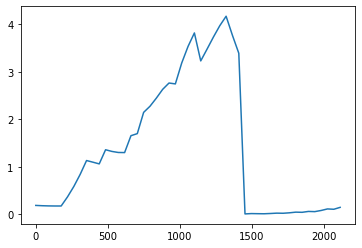

In [86]:
import matplotlib.pyplot as plt
plt.plot(pd1[::15].Qext)

## to do 

- Check data dimension
- Compare with Mie results